In [1]:
in_colab = False
try:
    import google.colab
    in_colab = True
except:
    in_colab = False
in_colab

True

In [2]:
if in_colab:
  !pip install neurokit2
  !pip install torchinfo
  !pip install pytorch_lightning
  !pip install wfdb
  #!pip install ssqueezepy
  !pip install pycwt
  #!pip install matplotlib==3.8
  #!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [3]:
import torch
from torch import optim, nn
from IPython.display import clear_output
from torchinfo import summary
import neurokit2 as nk
from sklearn.decomposition import PCA
from plotly import graph_objects as go
import os
import pywt as pw
from math import ceil
import cv2
from matplotlib import cm
from matplotlib import rcParams
import pytorch_lightning as pl
import imageio
import gc
import collections
from pytorch_lightning.loggers import Logger
from pytorch_lightning.loggers.logger import rank_zero_experiment
from pytorch_lightning.utilities import rank_zero_only
import scipy
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import ast
import os
import warnings
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
from scipy.signal import butter, lfilter, iirnotch

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

warnings.simplefilter(action='ignore', category=FutureWarning)
rcParams['font.weight'] = 'bold'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
channels = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
channels_map = {idx: channel for idx, channel in enumerate(channels)}

In [5]:
!python --version

Python 3.10.12


In [6]:
torch.__version__

'2.2.1+cu121'

In [7]:
torch.cuda.is_available()

True

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
%matplotlib inline

In [10]:
map_superclass_rev = {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}

In [11]:
if in_colab:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  %cd "drive/MyDrive/Colab Notebooks/ECG_SuperResolution"

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution


In [12]:
cwd = os.getcwd() + os.sep
path = cwd+"data"+os.sep+"PTBXL"+os.sep+"rawdata"+os.sep#"data\\1d\\PTBXL"+os.sep #your dataset path here
filename = path + "ptbxl_database.csv"
df = pd.read_csv(filename, sep=",", index_col="ecg_id")
df.head(20)

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
6,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,sinusrhythmus normales ekg,...,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr
7,16193.0,54.0,0,NaN,83.0,2.0,0.0,CS-12 E,1984-11-28 13:32:22,"sinusrhythmus linkstyp t abnormal, wahrscheinl...",...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00007_lr,records500/00000/00007_hr
8,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,sinusrhythmus linkstyp qrs(t) abnormal infe...,...,True,", II,AVF",", I-AVF,",NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr
9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr


In [13]:
n, m = df.shape
n, m

(21799, 27)

In [14]:
columns = df.columns
map_columns = {column: i for i, column in enumerate(columns)}
map_columns

{'patient_id': 0,
 'age': 1,
 'sex': 2,
 'height': 3,
 'weight': 4,
 'nurse': 5,
 'site': 6,
 'device': 7,
 'recording_date': 8,
 'report': 9,
 'scp_codes': 10,
 'heart_axis': 11,
 'infarction_stadium1': 12,
 'infarction_stadium2': 13,
 'validated_by': 14,
 'second_opinion': 15,
 'initial_autogenerated_report': 16,
 'validated_by_human': 17,
 'baseline_drift': 18,
 'static_noise': 19,
 'burst_noise': 20,
 'electrodes_problems': 21,
 'extra_beats': 22,
 'pacemaker': 23,
 'strat_fold': 24,
 'filename_lr': 25,
 'filename_hr': 26}

In [17]:
from functions import *

In [18]:
def resample_signal(data, fs=50, nchs = 12, fin = 50):

    data = data.cpu()

    secs = data.shape[-1]/(fin)
    size = int(fs*secs)

    resampled_data = []
    for ch in range(nchs):
        temp = scipy.signal.resample(x=data[ch, :], num=size)
        resampled_data.append(torch.from_numpy(temp))

    resampled_data = torch.stack(resampled_data)

    return resampled_data

In [50]:
device = "cuda:0"
model_d = torch.load("models/model_2_denoising_lrhr_v2.pt").to(device)
for block in model_d.decoder.decoder:
  block.last_tanh = False
for block in model_d.upsample.decoder:
  block.last_tanh = False

In [23]:
labels = list(map_superclass_rev.keys())
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_train_hr = {}
dict_windows_train_lr_n = {}
dict_windows_test_lr_n = {}

path = os.getcwd()+os.sep+"pt_data"+os.sep
for label in labels:

    if label == "All":
      continue
    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data

    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution/pt_data/test_All_hr.pt'

In [38]:
labels

['CD', 'HYP', 'MI', 'NORM', 'STTC', 'All']

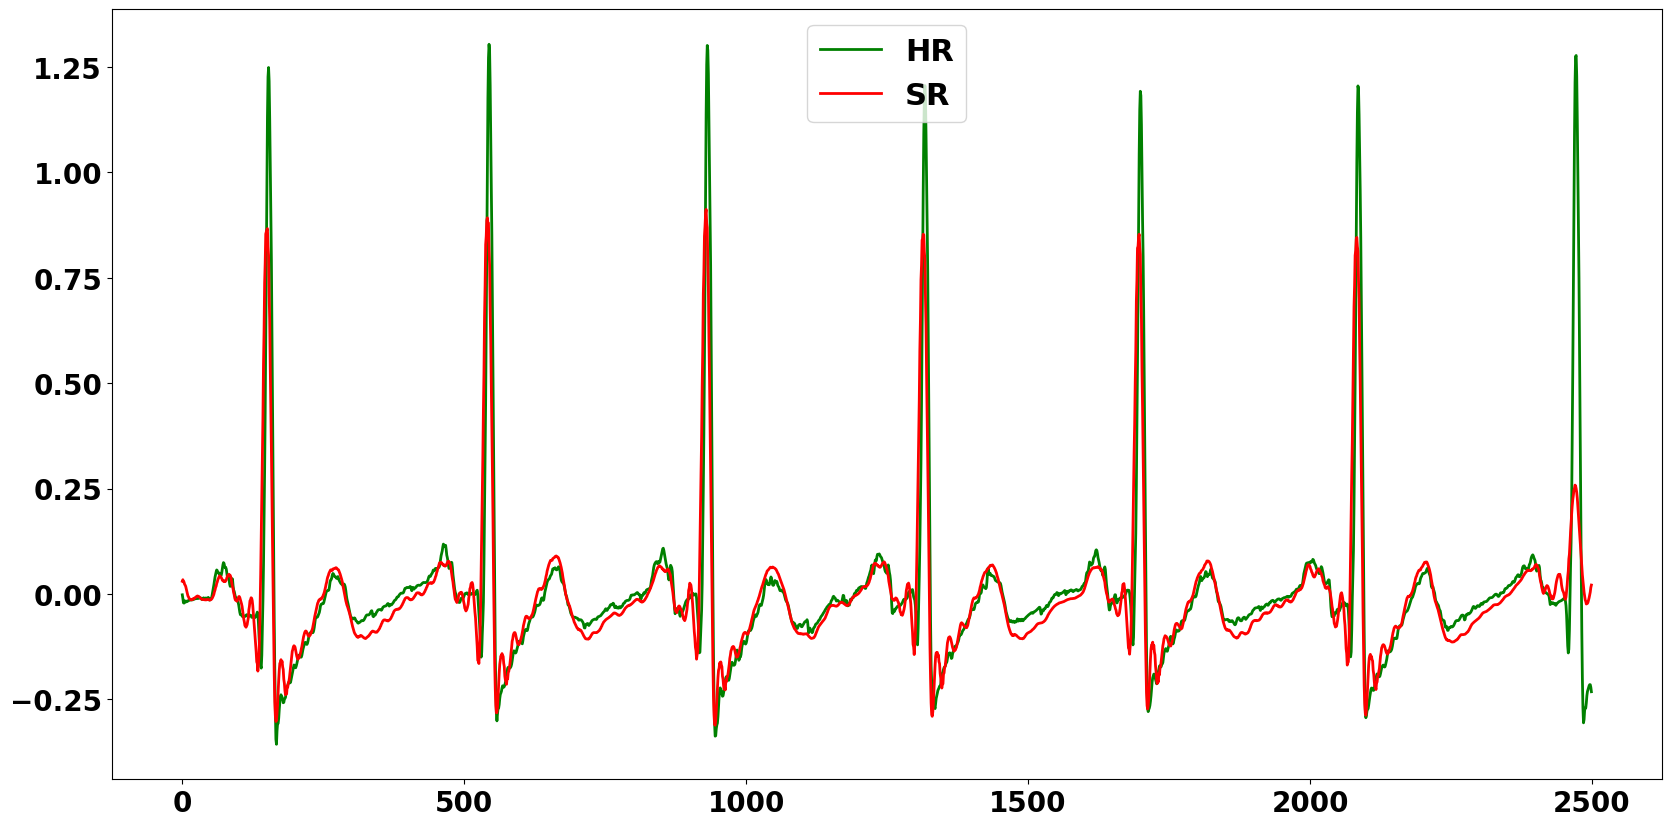

In [53]:
fig = plt.figure(figsize = (20, 10))
label = "HYP"
idx = 250
ch = 0
test_lr_n = dict_windows_train_lr[label][idx]
sr = model_d([test_lr_n, None])[1]

hr = dict_windows_train_hr[label][idx]
plt.plot(hr[0, ch, :].cpu().detach().numpy(), "g", label = "HR", linewidth = 2)
plt.plot(sr[ch, :].cpu().detach().numpy(), "r", label = "SR", linewidth = 2)
plt.legend()

In [54]:
import pandas as pd
import os

df = pd.read_csv(os.getcwd()+os.sep+"data"+os.sep+"ptbxl_database.csv")
df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21795,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21796,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21797,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr


In [55]:
df_statements = pd.read_csv(os.getcwd()+os.sep+"data"+os.sep+"scp_statements.csv")
df_statements

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,BIGU,"bigeminal pattern (unknown origin, SV or Ventr...",NaN,NaN,1.0,NaN,NaN,Statements related to ectopic rhythm abnormali...,"bigeminal pattern (unknown origin, SV or Ventr...",NaN,NaN,NaN,NaN
67,AFLT,atrial flutter,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,atrial flutter,51.0,MDC_ECG_RHY_ATR_FLUT,NaN,NaN
68,SVTAC,supraventricular tachycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,supraventricular tachycardia,55.0,MDC_ECG_RHY_SV_TACHY,NaN,D3-31290
69,PSVT,paroxysmal supraventricular tachycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,paroxysmal supraventricular tachycardia,NaN,MDC_ECG_RHY_SV_TACHY_PAROX,NaN,NaN


In [56]:
df_statements["Unnamed: 0"]

0       NDT
1      NST_
2       DIG
3     LNGQT
4      NORM
      ...  
66     BIGU
67     AFLT
68    SVTAC
69     PSVT
70    TRIGU
Name: Unnamed: 0, Length: 71, dtype: object

In [57]:
df.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

In [58]:
df_statements[df_statements["diagnostic_class"] == label]

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
7,LVH,left ventricular hypertrophy,1.0,NaN,NaN,HYP,LVH,Ventricular Hypertrophy,left ventricular hypertrophy,142.0,NaN,C71076,NaN
17,LAO/LAE,left atrial overload/enlargement,1.0,NaN,NaN,HYP,LAO/LAE,Atrial statements,left atrial overload/enlargement,140.0,NaN,NaN,NaN
28,RVH,right ventricular hypertrophy,1.0,NaN,NaN,HYP,RVH,Ventricular Hypertrophy,right ventricular hypertrophy,143.0,NaN,C71077,NaN
30,RAO/RAE,right atrial overload/enlargement,1.0,NaN,NaN,HYP,RAO/RAE,Atrial statements,right atrial overload/enlargement,141.0,NaN,NaN,NaN
37,SEHYP,septal hypertrophy,1.0,NaN,NaN,HYP,SEHYP,Ventricular Hypertrophy,septal hypertrophy,NaN,NaN,NaN,NaN


In [59]:
from ast import literal_eval

def find_patient(df, df_statements, label, number, test = True):

  if test:
    patients = df[df["strat_fold"] == 9]
  else:
    patients = df[df["strat_fold"] != 9]

  scp_codes = df_statements[df_statements["diagnostic_class"] == label]["Unnamed: 0"].values
  print(scp_codes)
  count = 0
  for index, patient in patients.iterrows():
    scp_code = patient["scp_codes"]
    scp_code = literal_eval(scp_code)
    if isinstance(scp_code, dict):
      codes = scp_code.keys()
      #print(codes)
      for code in codes:
        #print(code)
        if code in scp_codes:
          print(code)
          if count == 0:
            count+=1
          else:
            count+=2
          print(count)
          break
      if count >= number:
        return patient

  return patient

In [60]:
label = "STTC"
idx = 100
test_lr = dict_windows_train_lr[label][idx]
patient = find_patient(df, df_statements, label, idx, test = False)
patient

['NDT' 'NST_' 'DIG' 'LNGQT' 'ISC_' 'ISCAL' 'ISCIN' 'ISCIL' 'ISCAS' 'ISCLA'
 'ANEUR' 'EL' 'ISCAN']
NDT
1
NDT
3
NDT
5
ISCAL
7
NDT
9
NDT
11
NDT
13
ISCAL
15
ISCLA
17
NDT
19
NST_
21
ISC_
23
ISCAL
25
ISCAL
27
ISCAL
29
ANEUR
31
NDT
33
NDT
35
ISCIL
37
LNGQT
39
NDT
41
NST_
43
ISC_
45
ISC_
47
ISC_
49
NDT
51
ISC_
53
ISC_
55
ISCIN
57
ISC_
59
ISC_
61
ISC_
63
NDT
65
NDT
67
ISC_
69
ISC_
71
NDT
73
LNGQT
75
EL
77
NDT
79
NDT
81
ISC_
83
NDT
85
NDT
87
NDT
89
ISC_
91
ISC_
93
NST_
95
NDT
97
NDT
99
NDT
101


ecg_id                                                             369
patient_id                                                     15251.0
age                                                               55.0
sex                                                                  1
height                                                             NaN
weight                                                            63.0
nurse                                                              0.0
site                                                               0.0
device                                                       CS-12   E
recording_date                                     1986-11-21 10:33:37
report                          sinusrhythmus linkstyp qt-verlÄngerung
scp_codes                                    {'NDT': 100.0, 'SR': 0.0}
heart_axis                                                         LAD
infarction_stadium1                                                NaN
infarc

In [61]:
def load_raw_data(filename):
    signal, meta = wfdb.rdsamp(filename)
    signal = signal.T
    return signal, meta

In [62]:
!ls "/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution/data/PTBXL/rawdata/records100/21000"

21000_lr.dat  21120_lr.dat  21240_lr.dat  21360_lr.dat	21480_lr.dat  21600_lr.dat  21720_lr.dat
21000_lr.hea  21120_lr.hea  21240_lr.hea  21360_lr.hea	21480_lr.hea  21600_lr.hea  21720_lr.hea
21001_lr.dat  21121_lr.dat  21241_lr.dat  21361_lr.dat	21481_lr.dat  21601_lr.dat  21721_lr.dat
21001_lr.hea  21121_lr.hea  21241_lr.hea  21361_lr.hea	21481_lr.hea  21601_lr.hea  21721_lr.hea
21002_lr.dat  21122_lr.dat  21242_lr.dat  21362_lr.dat	21482_lr.dat  21602_lr.dat  21722_lr.dat
21002_lr.hea  21122_lr.hea  21242_lr.hea  21362_lr.hea	21482_lr.hea  21602_lr.hea  21722_lr.hea
21003_lr.dat  21123_lr.dat  21243_lr.dat  21363_lr.dat	21483_lr.dat  21603_lr.dat  21723_lr.dat
21003_lr.hea  21123_lr.hea  21243_lr.hea  21363_lr.hea	21483_lr.hea  21603_lr.hea  21723_lr.hea
21004_lr.dat  21124_lr.dat  21244_lr.dat  21364_lr.dat	21484_lr.dat  21604_lr.dat  21724_lr.dat
21004_lr.hea  21124_lr.hea  21244_lr.hea  21364_lr.hea	21484_lr.hea  21604_lr.hea  21724_lr.hea
21005_lr.dat  21125_lr.dat  21245_lr.dat

In [63]:
import os
cwd = os.getcwd()
sep = os.sep

print(patient)
filename = cwd + sep + "data" + sep + "PTBXL" + sep + "rawdata" + sep + patient[-2]
signal, meta = load_raw_data(filename)
signal, meta

ecg_id                                                             369
patient_id                                                     15251.0
age                                                               55.0
sex                                                                  1
height                                                             NaN
weight                                                            63.0
nurse                                                              0.0
site                                                               0.0
device                                                       CS-12   E
recording_date                                     1986-11-21 10:33:37
report                          sinusrhythmus linkstyp qt-verlÄngerung
scp_codes                                    {'NDT': 100.0, 'SR': 0.0}
heart_axis                                                         LAD
infarction_stadium1                                                NaN
infarc

(array([[ 0.944,  1.007,  0.046, ..., -0.054, -0.078, -0.088],
        [ 0.064, -0.239, -0.619, ...,  0.009, -0.019, -0.029],
        [-0.88 , -1.246, -0.665, ...,  0.063,  0.06 ,  0.059],
        ...,
        [ 0.4  ,  0.072, -0.484, ...,  0.06 ,  0.05 ,  0.039],
        [ 0.382,  0.049, -0.433, ...,  0.052,  0.043,  0.038],
        [ 0.292,  0.028, -0.345, ..., -0.004, -0.018, -0.032]]),
 {'fs': 100,
  'sig_len': 1000,
  'n_sig': 12,
  'base_date': None,
  'base_time': None,
  'units': ['mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV'],
  'sig_name': ['I',
   'II',
   'III',
   'AVR',
   'AVL',
   'AVF',
   'V1',
   'V2',
   'V3',
   'V4',
   'V5',
   'V6'],
  'comments': []})

In [64]:
signal.shape

(12, 1000)

In [65]:
from functions import *
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
font = {'family' : '',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

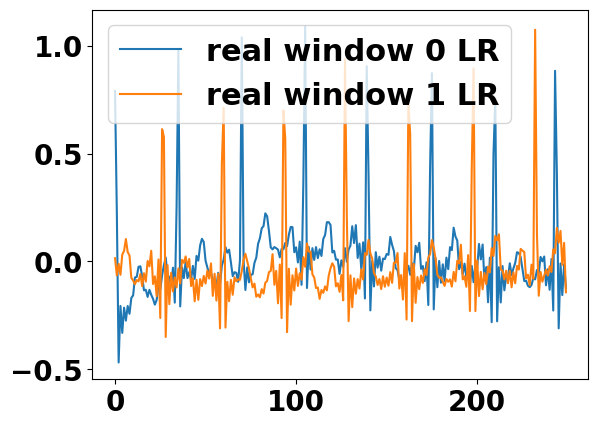

In [66]:
downsignal = resample_signal(torch.from_numpy(signal), fs=50, fin=100)
signal_filt = myfilter(0.05, downsignal)
fs = 50
windows = sliding_window(signal_filt, size = fs*5, stride = fs*5)
#label_num = map_superclass_rev[label]
#windows, _ = split_windows([signal_filt], [label_num], fs*5, stride = fs*5)
#windows = [window.squeeze(dim=0) for window in windows]

plt.figure()
plt.plot(windows[0][ch, :].to("cpu").detach().numpy(), label = "real window 0 LR")
plt.plot(windows[1][ch, :].to("cpu").detach().numpy(), label = "real window 1 LR")
plt.legend()

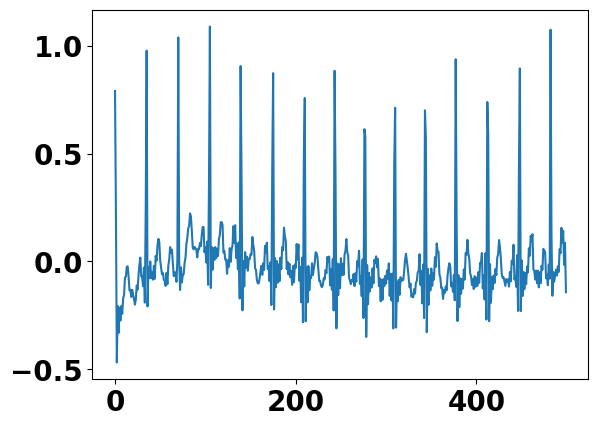

In [67]:
plt.plot(signal_filt[ch, :])

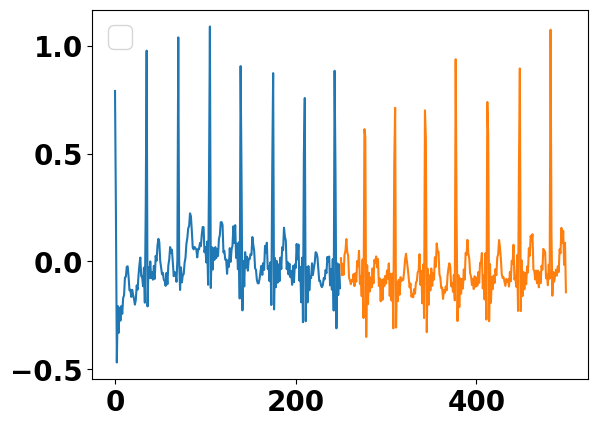

In [68]:
plt.plot(np.arange(0, 250), windows[0][ch, :].to("cpu").detach().numpy())
plt.plot(np.arange(250, 500), windows[1][ch, :].to("cpu").detach().numpy())
plt.legend()

In [69]:
idx

100

In [70]:
if idx%2 == 0:
  window_idx = 1
else:
  window_idx = 0
window_idx

1

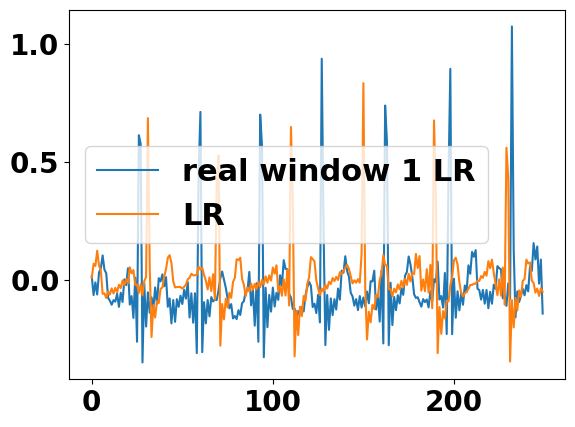

In [71]:
plt.plot(windows[window_idx][ch, :].to("cpu").detach().numpy(), label = "real window {} LR".format(window_idx))
plt.plot(test_lr[0, ch].to("cpu").detach().numpy(), label = "LR")
plt.legend()

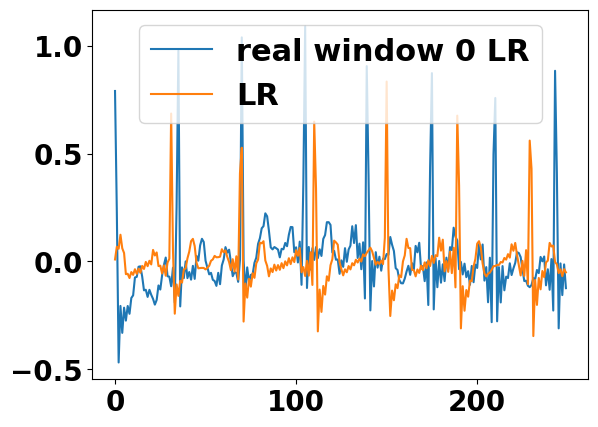

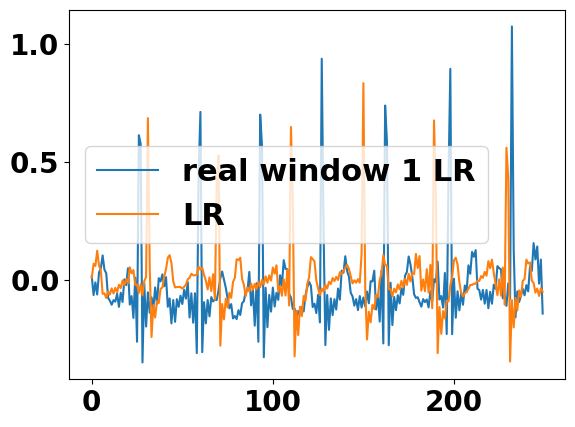

In [72]:
plt.plot(windows[0][ch, :].to("cpu").detach().numpy(), label = "real window 0 LR")
plt.plot(test_lr[0, ch].to("cpu").detach().numpy(), label = "LR")
plt.legend()


plt.figure()
plt.plot(windows[1][ch, :].to("cpu").detach().numpy(), label = "real window 1 LR")
plt.plot(test_lr[0, ch].to("cpu").detach().numpy(), label = "LR")
plt.legend()

In [78]:
df.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

In [75]:
patients_id = df.patient_id.values
patients_id

array([15709., 13243., 20372., ..., 19311.,  8873., 11744.])

In [82]:
#for patient_id in patients_id:
double_signal_patient = {}
for i, patient_id in enumerate(patients_id):
  print("\r", i+1, "/", len(patients_id), end = "")
  n, m = df[df["patient_id"] == patient_id].shape
  if n > 1:
    double_signal_patient[patient_id] = df[df["patient_id"] == patient_id]["filename_hr"].values

 21799 / 21799

In [83]:
double_signal_patient

{11031.0: array(['records500/00000/00012_hr', 'records500/00000/00200_hr'],
       dtype=object),
 13619.0: array(['records500/00000/00017_hr', 'records500/00000/00018_hr',
        'records500/00000/00020_hr', 'records500/00000/00023_hr',
        'records500/00000/00026_hr', 'records500/00000/00028_hr',
        'records500/00000/00034_hr', 'records500/00000/00039_hr'],
       dtype=object),
 8420.0: array(['records500/00000/00041_hr', 'records500/01000/01261_hr'],
       dtype=object),
 21409.0: array(['records500/00000/00053_hr', 'records500/00000/00246_hr'],
       dtype=object),
 20191.0: array(['records500/00000/00055_hr', 'records500/00000/00056_hr'],
       dtype=object),
 19987.0: array(['records500/00000/00073_hr', 'records500/01000/01255_hr'],
       dtype=object),
 19645.0: array(['records500/00000/00082_hr', 'records500/00000/00229_hr'],
       dtype=object),
 10366.0: array(['records500/00000/00086_hr', 'records500/00000/00895_hr'],
       dtype=object),
 10239.0: array(['r

In [87]:
df_statements.columns, df.columns

(Index(['Unnamed: 0', 'description', 'diagnostic', 'form', 'rhythm',
        'diagnostic_class', 'diagnostic_subclass', 'Statement Category',
        'SCP-ECG Statement Description', 'AHA code', 'aECG REFID', 'CDISC Code',
        'DICOM Code'],
       dtype='object'),
 Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
        'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
        'infarction_stadium1', 'infarction_stadium2', 'validated_by',
        'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
        'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
        'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
       dtype='object'))

In [98]:
n = len(double_signal_patient.keys())
n

2111

In [153]:
from collections import Counter

labels_patient = {}
for i, patient_id in enumerate(list(double_signal_patient.keys())):

    print("\r", i+1, "/", n, end = "")
    if patient_id not in labels_patient.keys():
      labels_patient[patient_id] = []

    scp_codes = df[df["patient_id"] == patient_id]["scp_codes"]
    for scp_codes_signal in scp_codes:
      scp_codes_signal = literal_eval(scp_codes_signal)
      temp_labels = []
      for scp_code in list(scp_codes_signal.keys()):
        temp_label =  df_statements[df_statements["Unnamed: 0"] == scp_code]["diagnostic_subclass"].values
        temp_labels.append(temp_label)
      temp_labels = np.array(temp_labels)
      counter = Counter(temp_labels.flat).most_common(1)
      label = counter[0][0]
      labels_patient[patient_id].append(label)

 2111 / 2111

In [144]:
df_statements["diagnostic_subclass"].isna().sum()

27

In [150]:
df_statements[df_statements["diagnostic_subclass"].isna() == True]

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
44,ABQRS,abnormal QRS,NaN,1.0,NaN,NaN,NaN,Normal/abnormal,abnormal QRS,NaN,NaN,NaN,NaN
45,PVC,ventricular premature complex,NaN,1.0,NaN,NaN,NaN,Statements related to ectopic rhythm abnormali...,ventricular premature complex (beat),60.0,MDC_ECG_BEAT_V_P_C,NaN,NaN
46,STD_,non-specific ST depression,NaN,1.0,NaN,NaN,NaN,Basic roots for coding ST-T changes and abnorm...,non-specific ST depression,502.0,NaN,NaN,F-38278
47,VCLVH,voltage criteria (QRS) for left ventricular hy...,NaN,1.0,NaN,NaN,NaN,Ventricular Hypertrophy,voltage criteria (QRS) for left ventricular hy...,NaN,NaN,NaN,NaN
48,QWAVE,Q waves present,NaN,1.0,NaN,NaN,NaN,Other QRS morphology descriptive statements,Q waves present,NaN,NaN,NaN,NaN
49,LOWT,low amplitude T-waves,NaN,1.0,NaN,NaN,NaN,other ST-T descriptive statements,low amplitude T-waves,366.0,NaN,NaN,NaN
50,NT_,non-specific T-wave changes,NaN,1.0,NaN,NaN,NaN,Basic roots for coding ST-T changes and abnorm...,non-specific T-wave changes,NaN,NaN,NaN,NaN
51,PAC,atrial premature complex,NaN,1.0,NaN,NaN,NaN,Statements related to ectopic rhythm abnormali...,atrial premature complex (beat),30.0,MDC_ECG_BEAT_ATR_P_C,NaN,NaN
52,LPR,prolonged PR interval,NaN,1.0,NaN,NaN,NaN,Statements related to impulse formation (abnor...,Prolonged PR interval,82.0,NaN,NaN,NaN
53,INVT,inverted T-waves,NaN,1.0,NaN,NaN,NaN,other ST-T descriptive statements,inverted T-waves,367.0,NaN,NaN,NaN


In [151]:
len(double_signal_patient[9740.0]), len(labels_patient[9740.0])

(5, 5)

In [154]:
labels_patient

{11031.0: ['NORM', 'NORM'],
 13619.0: [nan, nan, nan, nan, 'NST_', 'NST_', nan, 'STTC'],
 8420.0: ['LAFB/LPFB', nan],
 21409.0: ['NORM', 'NORM'],
 20191.0: ['NORM', 'NORM'],
 19987.0: [nan, nan],
 19645.0: ['NORM', 'NORM'],
 10366.0: ['NORM', 'NORM'],
 10239.0: ['NORM', 'NORM'],
 19832.0: ['NORM', 'NORM'],
 16747.0: ['NORM', 'NORM', 'NORM', 'NORM'],
 17735.0: ['STTC', 'STTC'],
 16463.0: ['NORM', 'NORM'],
 12640.0: [nan, 'LAFB/LPFB'],
 21551.0: ['AMI', 'AMI'],
 13112.0: ['IMI', 'AMI'],
 16322.0: ['NORM', 'NORM'],
 11070.0: ['NORM', 'NORM'],
 21519.0: ['STTC', nan],
 18264.0: ['NORM', 'NORM'],
 17115.0: ['AMI', nan],
 16654.0: ['NORM', 'NORM'],
 565.0: [nan, 'CLBBB', nan, 'CLBBB'],
 641.0: [nan, 'AMI'],
 449.0: [nan, nan, nan],
 340.0: [nan, nan],
 437.0: ['CLBBB', nan],
 603.0: ['NST_', 'NST_'],
 640.0: [nan, 'STTC'],
 380.0: [nan, 'NORM'],
 636.0: [nan, nan],
 20919.0: ['NORM', 'NORM', nan],
 15203.0: ['NORM', 'NORM', 'NORM'],
 11498.0: ['LAFB/LPFB', 'LAFB/LPFB'],
 10987.0: ['STTC', 'N

In [180]:
earlydet_patients = {}

for patient_id, labels in labels_patient.items():

  found_norm = False
  found_abn = False
  for label in labels:
    if label == "NORM":
      if not found_abn:
        found_norm = True
    elif not isinstance(label, float):
      found_abn = True

  if found_norm and found_abn:
    earlydet_patients[patient_id] = labels

In [181]:
len(earlydet_patients.keys())

104

In [182]:
earlydet_patients

{8412.0: ['NORM', 'STTC'],
 15838.0: ['NORM', 'NST_', 'AMI'],
 306.0: ['NORM', 'STTC'],
 16143.0: ['NORM', 'LVH'],
 499.0: ['NORM', 'AMI'],
 651.0: ['NORM', 'LAFB/LPFB'],
 14503.0: [nan, 'NORM', 'NST_'],
 11568.0: ['NORM', nan, 'IMI'],
 555.0: [nan, 'NORM', 'NST_'],
 515.0: ['NORM', 'STTC'],
 9960.0: ['NORM', 'NORM', 'NST_'],
 19435.0: ['NORM', 'STTC', 'NORM'],
 12807.0: ['NORM', 'STTC'],
 17915.0: ['NORM', 'ISCA'],
 10867.0: ['NORM', 'IRBBB'],
 19603.0: ['NORM', 'LVH'],
 21478.0: ['NORM', 'NORM', 'IRBBB'],
 21296.0: ['NORM', 'IRBBB'],
 320.0: ['NORM', 'STTC'],
 19462.0: ['NORM', 'AMI', 'AMI', 'AMI'],
 11103.0: ['NORM', 'NORM', '_AVB'],
 11972.0: ['NORM', 'IVCD'],
 21768.0: ['NORM', 'STTC'],
 319.0: ['NORM', 'AMI'],
 20728.0: ['NORM', 'IMI'],
 9992.0: ['NORM', 'STTC'],
 323.0: ['NORM', 'NST_'],
 13407.0: ['NORM', 'STTC'],
 11132.0: ['NORM', nan, 'NST_'],
 11899.0: ['NORM', 'STTC', 'NORM', 'STTC'],
 19996.0: ['NORM', 'STTC'],
 21520.0: ['NORM', nan, 'STTC'],
 10633.0: ['NORM', 'ISCI', '